# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

adj_r2 = lambda r2,n,d : 1-((1-r2)*(n-1)/(n-d-1))

pd.options.display.max_columns = None
plt.rcParams['figure.autolayout'] = True
warnings.filterwarnings('ignore')

----

# Problem Statement
Provide actionable insights to an Inditan edtech company by leveraging the power of machine learning to help their student base know in advance their chances of getting into a particular university based on metrics like GRE, GMAT, Toefl etc 

# Insights
- CGPA is the strongest predictor (weight ~ 0.069) for getting into a university of choice
- SOP and University Rating have a p-value > 5%, showing that these 2 don't have predictive power when it comes to chance of admission
- We built a robust Linear Regression model with following characteristics : 
    - R2 : 0.78
    - Adjusted R2 : 0.77
    - RMSE : 0.06
    - MAE : 0.05
    - Our model meets all underlying assumptions of a linear model

# Recommendations
- A student applying for a particular university should prioritize his application in the following order : CGPA >  GRE > TOEFL > LOR > Research > University Rating > SOP
- To boost performance of its models the edtech should collect additional data such as : 
    - Basic information : Age, Gender, Birth City
    - Education Background : Tier of Undergraduate College, Department
    - Work Background : Number of years of work/internships experience, Previous employees
    - Program information : Early/Late Stage applicant, Batch size, Applied Department, Course vintage 
- If the company deploys an accurate model on their website, this could lead in increase in traffic of students which could be used to generate revenues via: 
    - renting out ad space on the website
    - a subscription model (Rs X per prediction)
    - Provide counselling service to boost chances

# Loading

In [2]:
df = pd.read_csv('Admission.csv')

In [3]:
df.shape

(500, 9)

In [4]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df = df.drop(columns=['Serial No.'])

# EDA

## Non Visual EDA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


- No nulls observed

In [7]:
# Converting binary column to string type
df['Research'] = df['Research'].astype(str)

In [8]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,0.97000


In [9]:
df.describe(include='O')

,Research
count,500
unique,2
top,1
freq,280


## Visual EDA

### Univariate

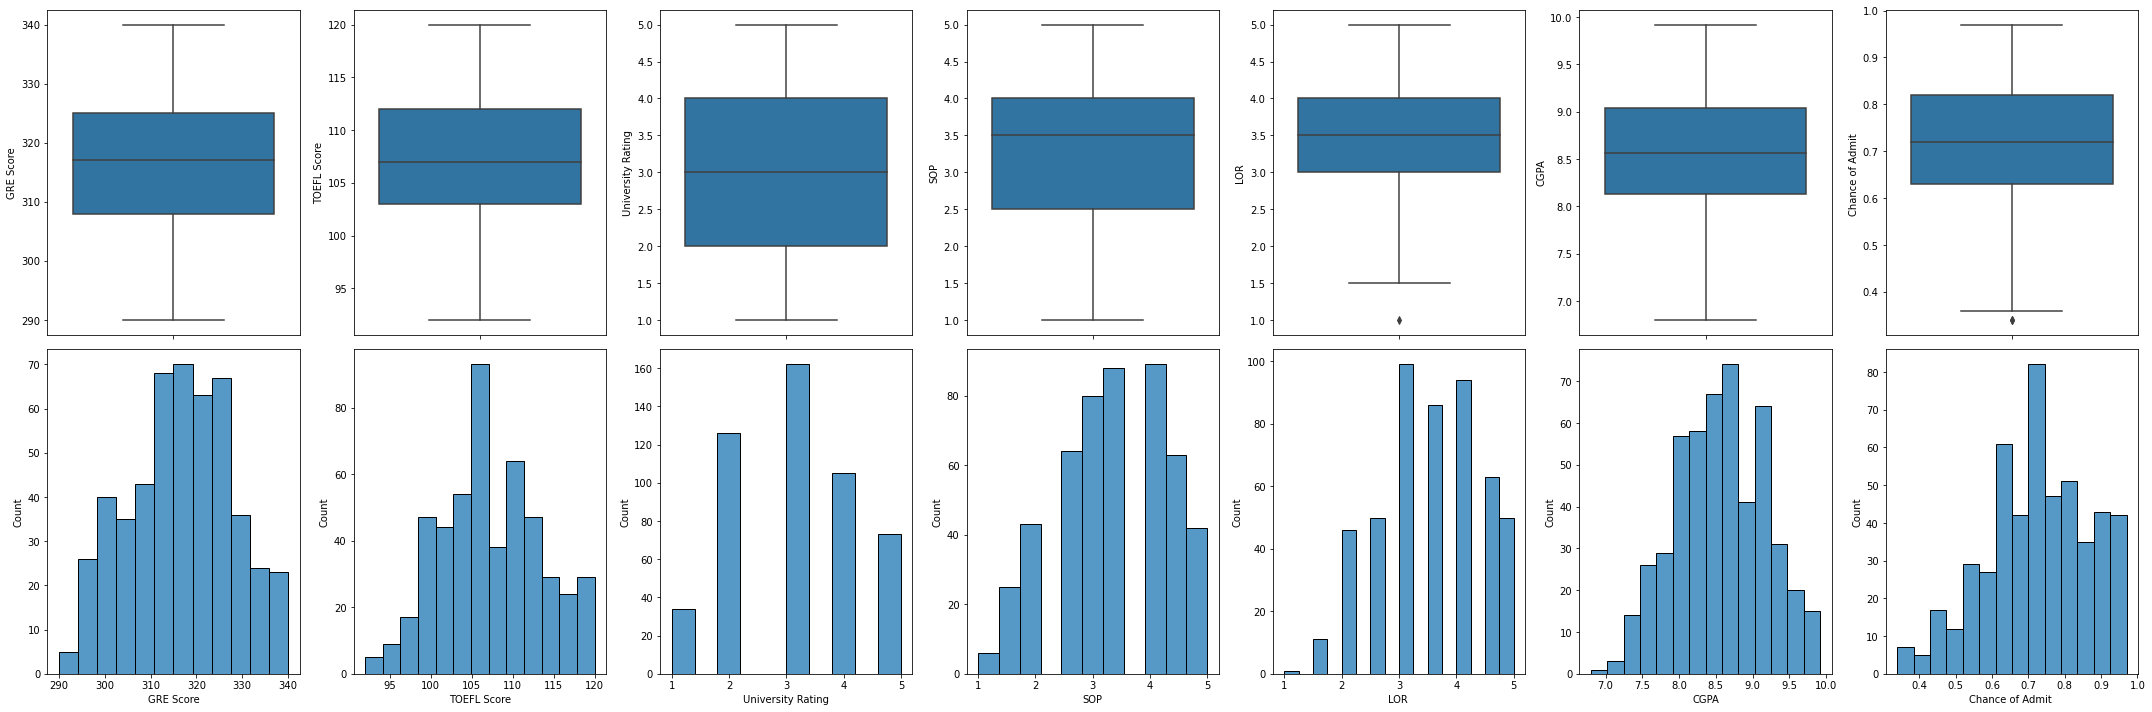

In [11]:
plt.rcParams['figure.figsize'] = 30,10
for e,c in enumerate(df.select_dtypes(exclude='O')):
    ax = plt.subplot(2,7,e+1)
    sns.boxplot(y=df[c],ax=ax)
for e,c in enumerate(df.select_dtypes(exclude='O')):
    ax = plt.subplot(2,7,e+8)
    sns.histplot(df[c],ax=ax)

- All of the numeric features seems to have a normal or a near-normal distribution
- LOR and chance of admit have outliers on the lower end

Text(0.5, 0, 'Research')

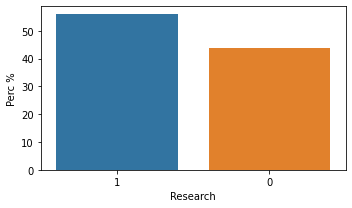

In [12]:
plt.rcParams['figure.figsize'] = 5,3
tmp = df['Research'].value_counts(1) * 100
g = sns.barplot(tmp.index, tmp.values)
g.set_ylabel('Perc %')
g.set_xlabel('Research')

- ~55% of students have prior research experience

### Bivariate

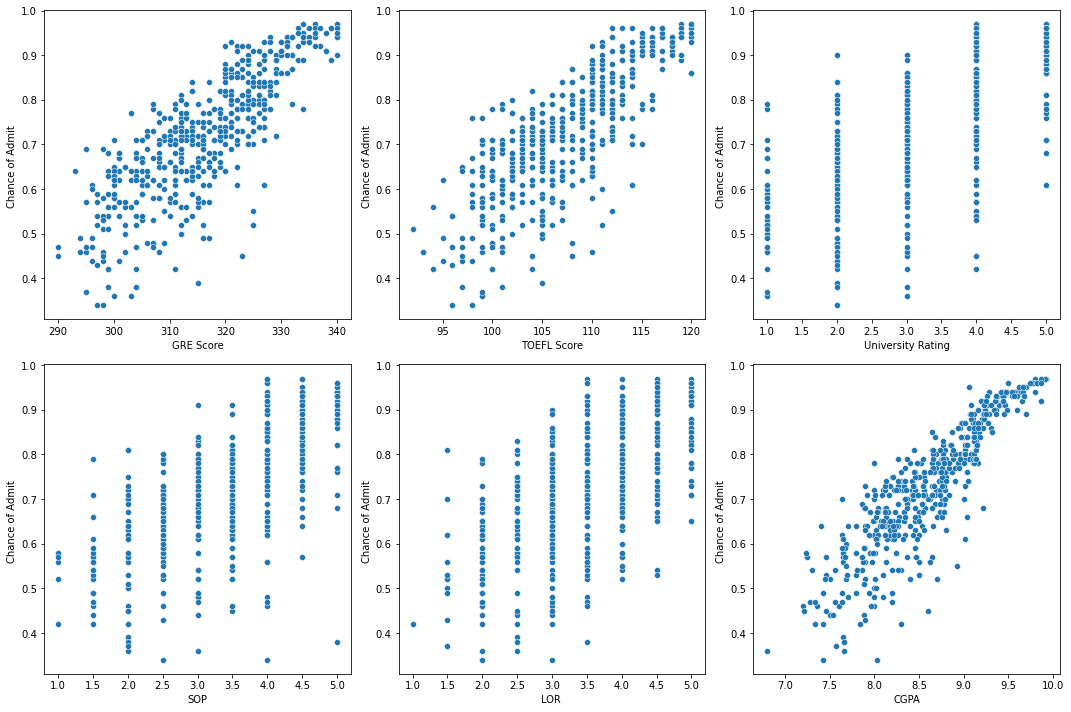

In [13]:
plt.rcParams['figure.figsize'] = 15,10
for e, c in enumerate(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']):
    ax = plt.subplot(2,3,e+1)
    sns.scatterplot(x=df[c], y=df['Chance of Admit '], ax=ax)

In [14]:
round(df[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']].corrwith(df['Chance of Admit '],method='spearman'),2).sort_values(ascending=False)

CGPA                 0.89
GRE Score            0.82
TOEFL Score          0.79
University Rating    0.70
SOP                  0.70
LOR                  0.64
dtype: float64

- All the numerical features have a strong positive correlation with Chance of Admit
- CGPA (0.89) and GRE score (0.82) having highest correlation with Change of Admit

Text(0.5, 0, 'Research')

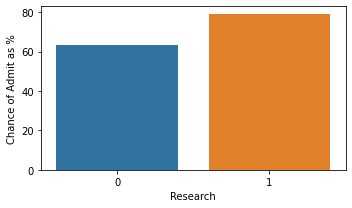

In [15]:
plt.rcParams['figure.figsize'] = 5,3
tmp = df.groupby('Research')['Chance of Admit '].mean() * 100
g = sns.barplot(tmp.index, tmp.values)
g.set_ylabel('Chance of Admit as %')
g.set_xlabel('Research')

- Students with Research experience have an 80% chance of admit on an average

----

# Data Preprocessing

In [16]:
df.duplicated().any()

False

- No duplicates

In [17]:
df.isna().sum().any()

False

- No nulls

As we saw in univariate charts LOR had outliers on lower end so we will remove them

In [18]:
med = df['LOR '].median()
IQR = df['LOR '].quantile(0.75) - df['LOR '].quantile(0.25)
q1 = df['LOR '].quantile(0.25)
q3 = df['LOR '].quantile(0.75)
df = df[(df['LOR '] >= q1 - 1.5*IQR) & (df['LOR '] <= q3 + 1.5*IQR)]

In [19]:
# one outlier has been dropped
df.shape

(499, 8)

In [20]:
# Preparing data for modelling
df.reset_index(drop=True, inplace=True)
X = df.drop(columns='Chance of Admit ').copy(deep=True)
y = df['Chance of Admit '].copy(deep=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
#Scaling features before using
ss = StandardScaler()
X_train.loc[:,:] = ss.fit_transform(X_train)
X_test.loc[:,:] = ss.transform(X_test)

---

# Model Building

In [23]:
def train_model(X_train, y_train, X_test, y_test, model):
    print(f'\n\n******************Model : {model.__class__.__name__}******************')
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat = model.predict(X_test)
    n,d = X_test.shape
    print('\nTraining Results :')
    generate_report(y_train, y_hat_train, d)
    print('\nTesting Results :')
    generate_report(y_test, y_hat, d)
    print('\nFeature Weights :\n', [str(X_train.columns[i]) + ' -> ' + str(round(model.coef_[i], 3)) for i in range(d)])
    print(f'intercept : {round(model.intercept_, 3)}')

def generate_report(y_test, y_hat, d):
    r2 = r2_score(y_test, y_hat)
    n = y_test.shape[0]
    print(f'\tR2 Score -> {round(r2, 2)}')
    print(f'\tAdj R2 Score -> {round(adj_r2(r2, n, d),2)}')
    print(f'\tRMSE -> {round(mean_squared_error(y_test, y_hat, squared=False), 2)}')
    print(f'\tMAE Score -> {round(mean_absolute_error(y_test, y_hat), 2)}')

## From sklearn

In [24]:
for model in [LinearRegression(), Lasso(alpha=0.01), Ridge(alpha=0.01), ElasticNet(alpha=0.01)]:
    train_model(X_train, y_train, X_test, y_test, model)



******************Model : LinearRegression******************

Training Results :
	R2 Score -> 0.83
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04

Testing Results :
	R2 Score -> 0.78
	Adj R2 Score -> 0.77
	RMSE -> 0.06
	MAE Score -> 0.05

Feature Weights :
 ['GRE Score -> 0.025', 'TOEFL Score -> 0.021', 'University Rating -> 0.003', 'SOP -> 0.001', 'LOR  -> 0.017', 'CGPA -> 0.069', 'Research -> 0.01']
intercept : 0.724


******************Model : Lasso******************

Training Results :
	R2 Score -> 0.82
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04

Testing Results :
	R2 Score -> 0.78
	Adj R2 Score -> 0.76
	RMSE -> 0.06
	MAE Score -> 0.05

Feature Weights :
 ['GRE Score -> 0.025', 'TOEFL Score -> 0.017', 'University Rating -> 0.001', 'SOP -> 0.0', 'LOR  -> 0.013', 'CGPA -> 0.071', 'Research -> 0.005']
intercept : 0.724


******************Model : Ridge******************

Training Results :
	R2 Score -> 0.83
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04



- Model is performing well in the unseen test set, giving a R2 score of 0.78, RMSE of 0.06
- CGPA is the strongest predictor of all
- Model performance can be increased by using more data sources and a larger data base

## From statsmodels

In [25]:
X_train_new = sm.add_constant(X_train)
X_test_new = sm.add_constant(X_test)

In [26]:
model = sm.OLS(y_train, X_train_new)
result = model.fit()

In [27]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     266.7
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          1.38e-144
Time:                        04:27:19   Log-Likelihood:                 560.96
No. Observations:                 399   AIC:                            -1106.
Df Residuals:                     391   BIC:                            -1074.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7236      0.00

- p-value of University Rating and SOP is higher than 5%, hence these are not relevant

In [28]:
y_hat_train = result.predict(X_train_new)
print('\nTraining:')
generate_report(y_train, y_hat_train, X_train_new.shape[1])
y_hat = result.predict(X_test_new)
print('\nTesting:')
generate_report(y_test, y_hat, X_test_new.shape[1])


Training:
	R2 Score -> 0.83
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04

Testing:
	R2 Score -> 0.78
	Adj R2 Score -> 0.76
	RMSE -> 0.06
	MAE Score -> 0.05


## From normal equation

In [29]:
theta = np.linalg.inv(X_train_new.T @ X_train_new) @ X_train_new.T  @ y_train

In [30]:
pd.DataFrame([X_train_new.columns, theta], index=['Feature','Weights']).T

,Feature,Weights
0,const,0.723609
1,GRE Score,0.025445
2,TOEFL Score,0.020628
3,University Rating,0.002809
4,SOP,0.001135
5,LOR,0.017351
6,CGPA,0.069341
7,Research,0.010076


In [31]:
y_hat_train = X_train_new.values @ theta
print('\nTraining:')
generate_report(y_train, y_hat_train, X_train_new.shape[1])
y_hat = X_test_new.values @ theta
print('\nTesting:')
generate_report(y_test, y_hat, X_test_new.shape[1])


Training:
	R2 Score -> 0.83
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04

Testing:
	R2 Score -> 0.78
	Adj R2 Score -> 0.76
	RMSE -> 0.06
	MAE Score -> 0.05


## From scratch using gradient descent

<AxesSubplot:>

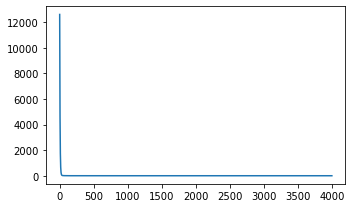

In [32]:
#initializing theta
theta = np.ones(X_train_new.shape[1]).T

#loss function
loss_function = lambda y_hat, y_true : np.sum((y_hat-y_true)**2)

costs = []
learning_rate = 0.01
iterations = 4000
n = X_train_new.shape[0]

#gradient descent
for _ in range(iterations):
    
    y_hat = X_train_new.values @ theta
    
    costs.append(loss_function(y_hat, y_train))
    
    d_theta = (2/n) * (X_train_new.T @ (y_hat - y_train)) 
                        
    theta = theta - learning_rate * d_theta
    
sns.lineplot(range(len(costs)), costs)

In [33]:
theta

const                0.723609
GRE Score            0.025445
TOEFL Score          0.020628
University Rating    0.002809
SOP                  0.001136
LOR                  0.017351
CGPA                 0.069341
Research             0.010076
dtype: float64

In [35]:
y_hat_train = X_train_new.values @ theta
print('\nTraining:')
generate_report(y_train, y_hat_train, X_train_new.shape[1])
y_hat = X_test_new.values @ theta
print('\nTesting:')
generate_report(y_test, y_hat, X_test_new.shape[1])


Training:
	R2 Score -> 0.83
	Adj R2 Score -> 0.82
	RMSE -> 0.06
	MAE Score -> 0.04

Testing:
	R2 Score -> 0.78
	Adj R2 Score -> 0.76
	RMSE -> 0.06
	MAE Score -> 0.05


# Assumptions

## Assumption 1 : No Multicollinearity

In [36]:
for c in X_train.columns:
    
    x = X_train.drop(columns=[c])
    Y = X_train[c]
    
    model = LinearRegression()
    model.fit(x, Y)
    
    Y_TEST = X_test[c]
    Y_HAT = model.predict(X_test.drop(columns=[c]))
    
    r2 = r2_score(Y_TEST, Y_HAT)
    vif = 1/(1-r2)
    print(c,'->',round(vif,3))

GRE Score -> 3.784
TOEFL Score -> 4.921
University Rating -> 2.148
SOP -> 2.441
LOR  -> 1.697
CGPA -> 4.376
Research -> 1.197


None of the features have VIF greater than 5. So no significant multicolinearity detected

---

## Assumption 2 :  The mean of residuals is nearly zero

In [37]:
residuals = y_hat - y_test

In [38]:
round(residuals.mean(),3)

-0.004

This assumption also holds

---

## Assumption 3 : Linearity of variables

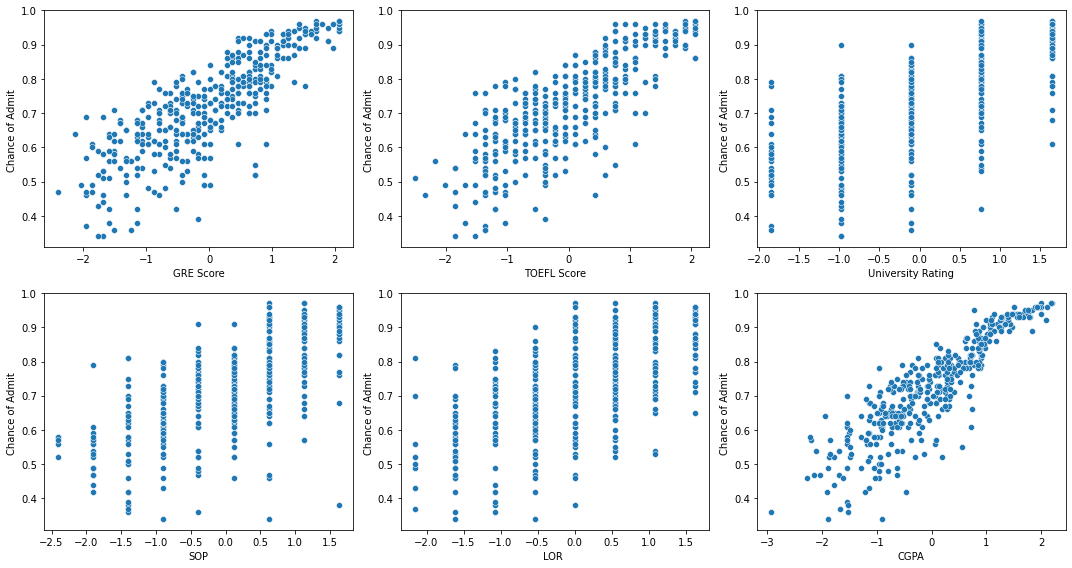

In [39]:
plt.rcParams['figure.figsize'] = 15,8
for e, c in enumerate(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']):
    ax = plt.subplot(2,3,e+1)
    sns.scatterplot(x=X_train[c], y=y_train, ax=ax)

As we can see from the scatterplots, that all the variables show linear relationship with y (Chance of admit)

## Assumption 4 : Homoscedasticity

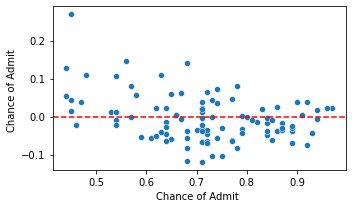

In [40]:
plt.rcParams['figure.figsize'] = 5,3
g = sns.scatterplot(y_test, residuals)
g.axhline(0, ls='--', c='r')

This assumption is also holds as we dont really see a tunnel shape here which would have suggested Homoscedasticity

## Assumption 5 : Normality of residuals

<AxesSubplot:xlabel='Chance of Admit ', ylabel='Count'>

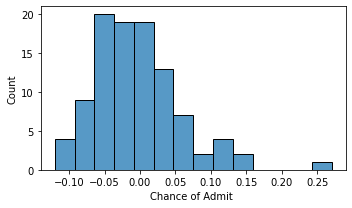

In [41]:
sns.histplot(residuals)

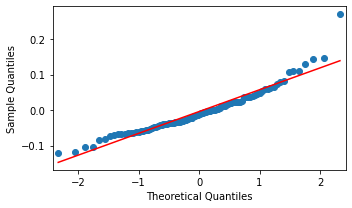

In [42]:
qqplot(residuals.values, line='r')
plt.show()

The residuals also follow the normal distribution

---